In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error,r2_score
from datetime import date
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [2]:
df = pd.read_csv("FTB_Data_2025_06_19.csv")

In [3]:
df

,Unnamed: 0,BASICSHIM,BENCH_NAME,DATE_AND_TIME_LOCAL,DATE_AND_TIME,LHSSHIM,RHSSHIM,SHIMTYPE,TYPE
0,0,1.44,Line 2 PS1,2025-06-19T09:13:55.013,Jun 19 2025 9:13AM,1.41,1.41,2430 100 976,250+8=020
1,1,1.44,Line 2 PS1,2025-06-19T09:13:31.230,Jun 19 2025 9:13AM,1.47,1.51,2430 100 976,250+8=020
2,2,1.44,Line 2 PS1,2025-06-19T09:13:06.020,Jun 19 2025 9:13AM,1.28,1.44,2430 100 976,250+8=020
3,3,1.44,Line 2 PS1,2025-06-19T09:12:41.513,Jun 19 2025 9:12AM,1.44,1.40,2430 100 976,250+8=020
4,4,1.44,Line 2 PS1,2025-06-19T09:12:09.063,Jun 19 2025 9:12AM,1.42,1.57,2430 100 976,250+8=020
...,...,...,...,...,...,...,...,...,...
99995,99995,1.92,Line 2 PS1,2025-03-08T16:49:02.307,Mar 8 2025 4:49PM,1.92,1.84,2430 100 976,250+10
99996,99996,1.92,Line 2 PS1,2025-03-08T16:48:37.777,Mar 8 2025 4:48PM,1.96,1.80,2430 100 976,250+10
99997,99997,1.92,Line 2 PS1,2025-03-08T16:48:11.197,Mar 8 2025 4:48PM,1.88,1.96,2430 100 976,250+10
99998,99998,1.92,Line 2 PS1,2025-03-08T16:47:39.703,Mar 8 2025 4:47PM,1.83,1.82,2430 100 976,250+10


In [4]:
df.isna().sum()

Unnamed: 0              0
BASICSHIM               0
BENCH_NAME              0
DATE_AND_TIME_LOCAL     0
DATE_AND_TIME           0
LHSSHIM                 0
RHSSHIM                 0
SHIMTYPE               53
TYPE                    0
dtype: int64

In [5]:
df.drop(columns=["Unnamed: 0"],axis=1,inplace=True)
df.fillna(df.median(numeric_only=True),inplace=True)

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
BASICSHIM,100000.0,1.595948,0.193975,1.28,1.43,1.50,1.80,1.99
LHSSHIM,100000.0,1.620318,0.289052,0.00,1.43,1.54,1.80,3.60
RHSSHIM,100000.0,1.600535,0.260172,0.00,1.42,1.53,1.79,3.60


0.6198473827781116

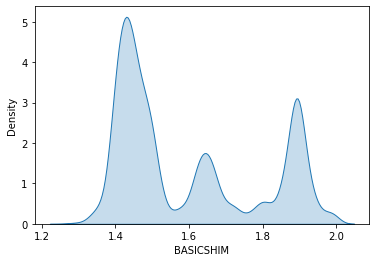

In [7]:
sns.kdeplot(df['BASICSHIM'],fill = True)
df['BASICSHIM'].skew()

2.369485997378689

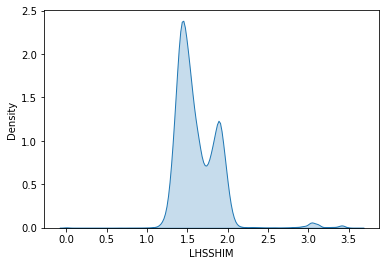

In [8]:
sns.kdeplot(df['LHSSHIM'],fill = True , label = "line_plot")
df['LHSSHIM'].skew()

2.0595897597400823

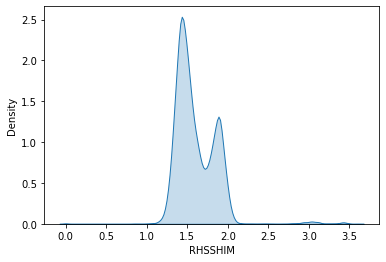

In [9]:
sns.kdeplot(df['RHSSHIM'],fill=True)
df['RHSSHIM'].skew()

In [10]:
selected_features = ["BASICSHIM","LHSSHIM","RHSSHIM"]

for col in selected_features:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    median = df[col].median()
    
    df[col] = np.where((df[col] < lower_bound) | (df[col] > upper_bound), median, df[col])


df

,BASICSHIM,BENCH_NAME,DATE_AND_TIME_LOCAL,DATE_AND_TIME,LHSSHIM,RHSSHIM,SHIMTYPE,TYPE
0,1.44,Line 2 PS1,2025-06-19T09:13:55.013,Jun 19 2025 9:13AM,1.41,1.41,2430 100 976,250+8=020
1,1.44,Line 2 PS1,2025-06-19T09:13:31.230,Jun 19 2025 9:13AM,1.47,1.51,2430 100 976,250+8=020
2,1.44,Line 2 PS1,2025-06-19T09:13:06.020,Jun 19 2025 9:13AM,1.28,1.44,2430 100 976,250+8=020
3,1.44,Line 2 PS1,2025-06-19T09:12:41.513,Jun 19 2025 9:12AM,1.44,1.40,2430 100 976,250+8=020
4,1.44,Line 2 PS1,2025-06-19T09:12:09.063,Jun 19 2025 9:12AM,1.42,1.57,2430 100 976,250+8=020
...,...,...,...,...,...,...,...,...
99995,1.92,Line 2 PS1,2025-03-08T16:49:02.307,Mar 8 2025 4:49PM,1.92,1.84,2430 100 976,250+10
99996,1.92,Line 2 PS1,2025-03-08T16:48:37.777,Mar 8 2025 4:48PM,1.96,1.80,2430 100 976,250+10
99997,1.92,Line 2 PS1,2025-03-08T16:48:11.197,Mar 8 2025 4:48PM,1.88,1.96,2430 100 976,250+10
99998,1.92,Line 2 PS1,2025-03-08T16:47:39.703,Mar 8 2025 4:47PM,1.83,1.82,2430 100 976,250+10


0.6198473827781116

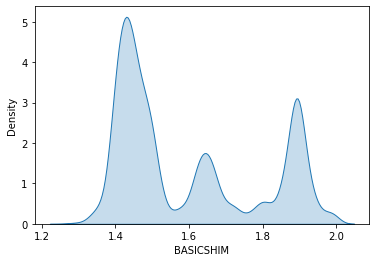

In [11]:
sns.kdeplot(df['BASICSHIM'],fill=True)
df['BASICSHIM'].skew()

0.4873497765434975

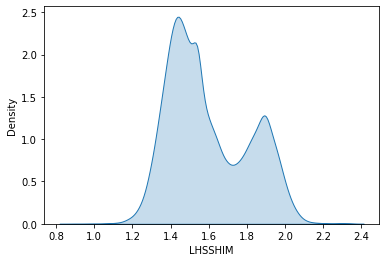

In [12]:
sns.kdeplot(df['LHSSHIM'],fill=True)
df['LHSSHIM'].skew()

0.47941314409605085

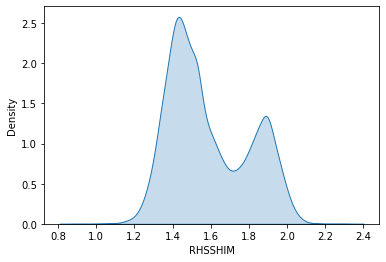

In [13]:
sns.kdeplot(df['RHSSHIM'],fill=True)
df['RHSSHIM'].skew()

In [14]:
train_df , test_df = train_test_split(df,test_size=0.2,random_state=42)

In [15]:
# train_df.to_csv("NHA_training_data.csv")
# test_df.to_csv("NHA_test_data.csv")

In [16]:
X = df[["LHSSHIM","RHSSHIM","TYPE"]].copy()
X['TYPE'] = X['TYPE'].astype('category')

y = df["BASICSHIM"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

In [17]:
print(X["LHSSHIM"].shape, X["RHSSHIM"].shape, y.shape)

(100000,) (100000,) (100000,)


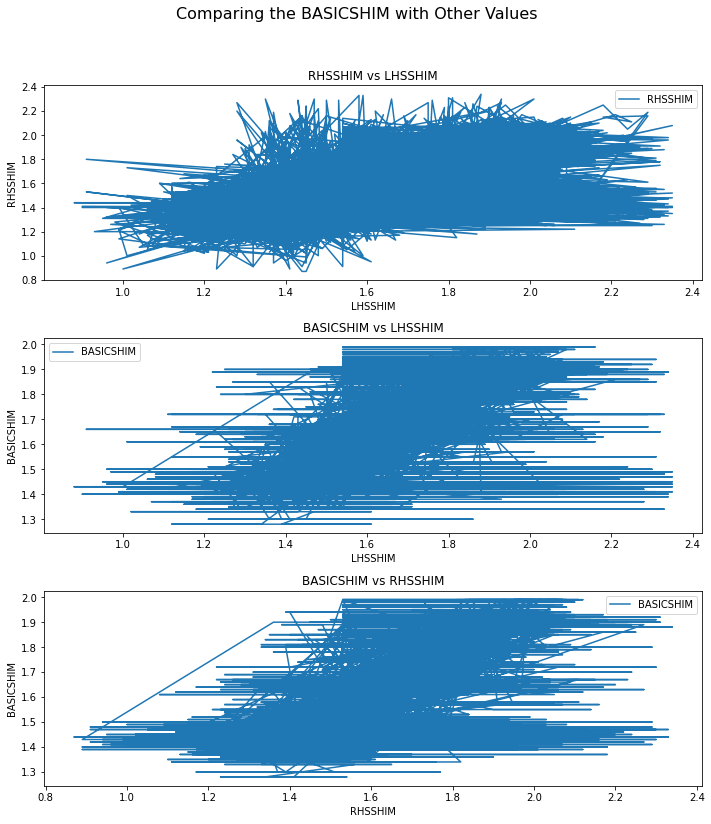

In [18]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

axes[0].plot(X["LHSSHIM"], X["RHSSHIM"], label="RHSSHIM")
axes[0].set_title("RHSSHIM vs LHSSHIM")
axes[0].set_xlabel("LHSSHIM")
axes[0].set_ylabel("RHSSHIM")
axes[0].legend()

axes[1].plot(X["LHSSHIM"], y, label="BASICSHIM")
axes[1].set_title("BASICSHIM vs LHSSHIM")
axes[1].set_xlabel("LHSSHIM")
axes[1].set_ylabel("BASICSHIM")
axes[1].legend()

axes[2].plot(X["RHSSHIM"], y, label="BASICSHIM")
axes[2].set_title("BASICSHIM vs RHSSHIM")
axes[2].set_xlabel("RHSSHIM")
axes[2].set_ylabel("BASICSHIM")
axes[2].legend()

fig.suptitle("Comparing the BASICSHIM with Other Values", fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()


In [19]:
param_dist = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [4, 6],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [20]:
cmodel = CatBoostRegressor(iterations = 200,
                           max_depth = 8,
                           learning_rate = 0.05,
                           subsample = 1.0,
                           verbose=0,
                           loss_function="RMSE",
                           random_state=42)

cmodel.fit(X_train, y_train, cat_features=['TYPE'])
y_pred = cmodel.predict(X_test)

mse = mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mse)
r2_scores = r2_score(y_test,y_pred)

print(f"Mean Squared Error -> {mse*100:.2f}%")
print(f"Root Mean Square Error -> {rmse:.2f}%")
print(f"R2 Score -> {r2_scores*100:.2f}%")

Mean Squared Error -> 0.39%
Root Mean Square Error -> 0.06%
R2 Score -> 89.72%


In [21]:
lmodel = LGBMRegressor(
    random_state=123,
    n_jobs=-1,
    verbose=-1
)
random_search = RandomizedSearchCV(
    estimator=lmodel,
    param_distributions=param_dist,
    n_iter=20,              
    cv=3,
    scoring='r2',
    verbose=0,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print("Best Parameters:", best_params)


Best Parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 1.0}


In [22]:
final_lmodel = LGBMRegressor(
    **best_params,
    verbose=-1,
    n_jobs=-1,
    random_state=123
)
final_lmodel.fit(X_train, y_train)
y_predictions = final_lmodel.predict(X_test)


mse = mean_squared_error(y_test, y_predictions)
rmse = np.sqrt(mse)
r2_scores = r2_score(y_test, y_predictions)

print(f"Mean Squared Error -> {mse:.4f}mm²")
print(f"Root Mean Square Error -> {rmse:.4f}mm²")
print(f"R2 Score -> {r2_scores*100:.2f}%")

Mean Squared Error -> 0.0038mm²
Root Mean Square Error -> 0.0613mm²
R2 Score -> 90.00%


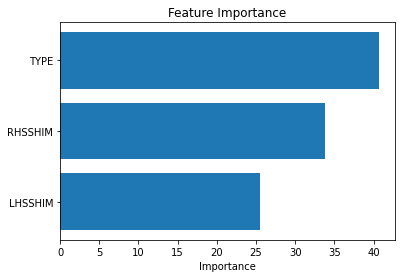

In [23]:
feature_importance = cmodel.get_feature_importance()
feature_names = X.columns

plt.barh(feature_names, feature_importance)
plt.xlabel("Importance")
plt.title("Feature Importance")
plt.show()


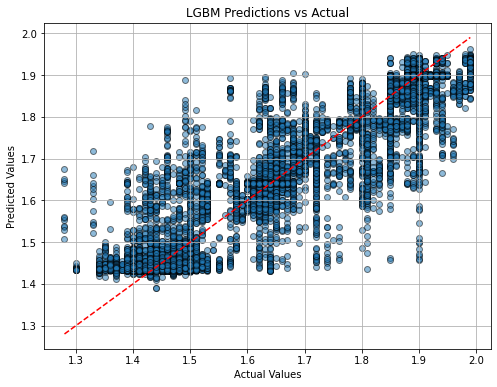

In [24]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_predictions, alpha=0.5 , ec = "k")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("LGBM Predictions vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.grid(True)
plt.show()

In [25]:
X_train_encoded = pd.get_dummies(X_train, columns=['TYPE'], drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=['TYPE'], drop_first=True)

X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

In [26]:
xgb_model = XGBRegressor(random_state=123)

xgb_model.fit(X_train_encoded, y_train)

y_pred_xgb = xgb_model.predict(X_test_encoded)

# Evaluate
mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_xgb)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2 * 100:.2f}%")


MSE: 0.0038
RMSE: 0.0618
R² Score: 89.83%


In [27]:
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import StackingRegressor

lgb_model = LGBMRegressor(**best_params, random_state=123, n_jobs=-1, verbose=-1)

cat_model = CatBoostRegressor(
    verbose=0,
    cat_features=["TYPE"],
    random_state=123
)

In [28]:
df["DATE_AND_TIME_LOCAL"] = pd.to_datetime(df["DATE_AND_TIME_LOCAL"])

In [29]:
df["DATE_AND_TIME_LOCAL"].tail(12)

99988   2025-03-08 16:52:01.500
99989   2025-03-08 16:51:36.280
99990   2025-03-08 16:51:12.500
99991   2025-03-08 16:50:49.400
99992   2025-03-08 16:50:23.493
99993   2025-03-08 16:49:54.787
99994   2025-03-08 16:49:28.890
99995   2025-03-08 16:49:02.307
99996   2025-03-08 16:48:37.777
99997   2025-03-08 16:48:11.197
99998   2025-03-08 16:47:39.703
99999   2025-03-08 16:43:15.100
Name: DATE_AND_TIME_LOCAL, dtype: datetime64[ns]